## Note, only using comments_df for now until we figure out if it is worth it to use the posts_df as well somehow

# 1: Import Packages, define functions


In [167]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import mysql.connector
# some_file.py
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod4/Reddit_NLP/Scripts')
#import config
pd.set_option('display.max_columns', 300)

%matplotlib inline

In [168]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [169]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [170]:
# we can define a function that removes stopwords 
def process_comment(comment):
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [171]:
def capital_percentage(comment):
    tokens = nltk.word_tokenize(comment)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)



In [172]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http"]

# 2: Load in the data

In [173]:
posts_df = pd.read_csv('/Users/alecmccabe/Desktop/Flatiron/Projects/Mod4/Reddit_NLP/csv_data/posts_df.csv', index_col=0)
comments_df = pd.read_csv('/Users/alecmccabe/Desktop/Flatiron/Projects/Mod4/Reddit_NLP/csv_data/comments_df.csv', index_col=0)

In [174]:
posts_df.columns = ['id_num', 'post_title', 'post_author', 'post_upvote_ratio', 'post_id', 'post_class']

In [175]:
comments_df.columns = ['id_num', 'body', 'comment_id', 'parent_id', 'post_id', 'author', 'score', 'comment_class']

In [176]:
import re

pattern = '\w+_(\w+)'
p = re.compile(pattern)

In [177]:
comments_df.post_id = comments_df.post_id.apply(lambda x: p.findall(x)[0])

In [178]:
# GET RID OF NEGATIVE SCORES (a negative score in a conservative subreddit could be a brigader for example)
comments_df = comments_df[comments_df.score > 0]

In [179]:
df = comments_df[['body', 'comment_class']]

In [180]:
df.comment_class.value_counts()

left     52771
right    39950
Name: comment_class, dtype: int64

# 3: Initial EDA

In [181]:
df['capital_percentage'] = df.body.apply(capital_percentage)

<ipython-input-181-8329d89493b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capital_percentage'] = df.body.apply(capital_percentage)


In [182]:
all_caps = df[df.capital_percentage == 1].sort_values(by='capital_percentage', 
                                                      ascending=False).comment_class.value_counts()

In [183]:
comments_w_most_caps = df.sort_values(by='capital_percentage', 
                                      ascending=False).iloc[0:500].comment_class.value_counts()

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

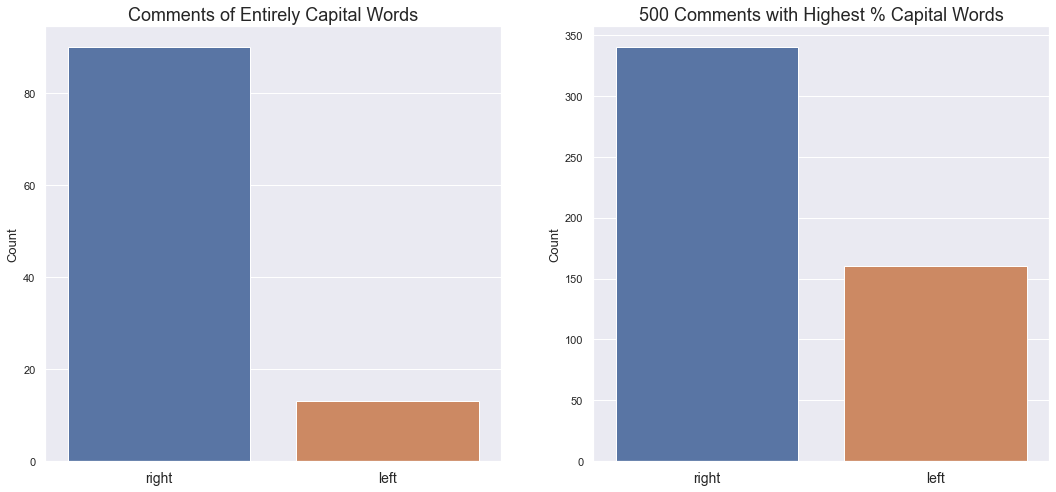

In [184]:
fig = plt.figure(figsize=(18,8))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(all_caps.index, all_caps, ax=ax1)
plt.title("Comments of Entirely Capital Words", fontsize = 18)
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=14)

ax2 = plt.subplot(1, 2, 2)
sns.barplot(comments_w_most_caps.index, comments_w_most_caps, ax=ax2)
plt.title("500 Comments with Highest % Capital Words", fontsize = 18)
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=14)


In [185]:
leaning_map = {'right': 1, 'left': 0}
df.comment_class = df.comment_class.map(leaning_map)

/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [186]:
df['text_len'] = df['body'].map(lambda x: len(x))

<ipython-input-186-67af6b43cc2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['body'].map(lambda x: len(x))


In [187]:
df = df[df.text_len >= 100]
df.drop('text_len', axis=1, inplace=True)

In [188]:
df.comment_class.value_counts()

0    26077
1    20134
Name: comment_class, dtype: int64

In [189]:
from sklearn.utils import resample
right = df[df.comment_class == 1]
left = df[df.comment_class == 0]

right_upsampled = resample(right,
                          replace=True, # sample with replacement
                          n_samples=len(left), # match number in majority class
                          random_state=42) 
df = pd.concat([left, right_upsampled])
df.comment_class.value_counts()

1    26077
0    26077
Name: comment_class, dtype: int64

In [141]:
df_freq_right = df[df['comment_class']==1]
df_freq_left = df[df['comment_class']==0]

data_right = df_freq_right['body']
data_left = df_freq_left['body']

processed_right = list(map(process_comment, data_right))
processed_left = list(map(process_comment, data_left))

In [142]:
# Preprocessing:
# We will use these again later on
# FORMAT:  flat_list = [item for sublist in l for item in sublist]

flat_right = [item for sublist in processed_right for item in sublist]
flat_left = [item for sublist in processed_left for item in sublist]

In [143]:
right_freq = FreqDist(flat_right)
left_freq = FreqDist(flat_left)

In [144]:
right_freq.most_common(20)

[('gun', 8006),
 ('people', 7588),
 ('like', 5064),
 ('would', 4635),
 ('get', 3839),
 ('one', 3777),
 ('guns', 3748),
 ('vote', 3582),
 ('right', 3459),
 ('https', 3272),
 ('republicans', 3163),
 ('trump', 3043),
 ('think', 2998),
 ('want', 2889),
 ('even', 2847),
 ('...', 2807),
 ('biden', 2704),
 ('rights', 2602),
 ('know', 2512),
 ('going', 2267)]

In [145]:
left_freq.most_common(20)

[('trump', 10513),
 ('https', 8863),
 ('people', 7590),
 ('vote', 6696),
 ('please', 5588),
 ('subreddit', 5113),
 ('voting', 4825),
 ('like', 4490),
 ('would', 4152),
 ('biden', 3685),
 ('questions', 3557),
 ('see', 3269),
 ('get', 3046),
 ('one', 2882),
 ('even', 2495),
 ('going', 2371),
 ('...', 2370),
 ('early', 2299),
 ('media', 2237),
 ('hate', 2174)]

In [146]:
# create counts of satire and not satire with values and words
right_bar_counts = [x[1] for x in right_freq.most_common(25)]
right_bar_words = [x[0] for x in right_freq.most_common(25)]

left_bar_counts = [x[1] for x in left_freq.most_common(25)]
left_bar_words = [x[0] for x in left_freq.most_common(25)]

In [147]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

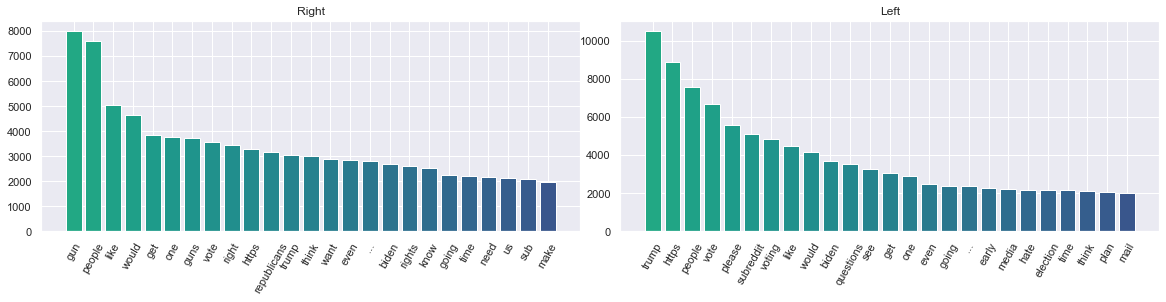

In [148]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(right_bar_words, right_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(left_bar_words, left_bar_counts, color=color )

ax.title.set_text('Right')
ax2.title.set_text('Left')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

In [149]:
# Getting our data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))
#!pip install wordcloud
from wordcloud import WordCloud
right_dictionary = dict(zip(right_bar_words, right_bar_counts))
left_dictionary = dict(zip(left_bar_words, left_bar_counts))

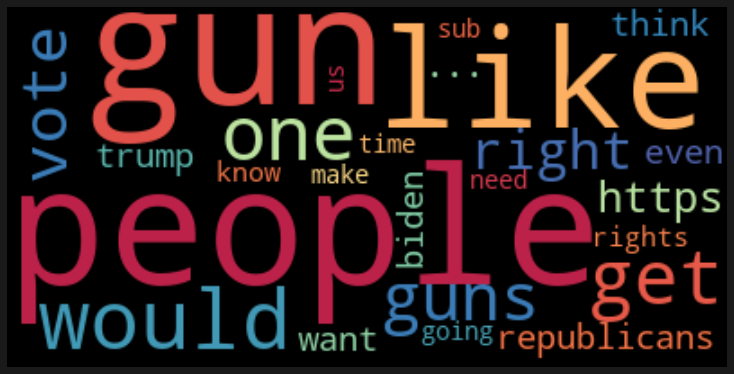

In [150]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(right_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

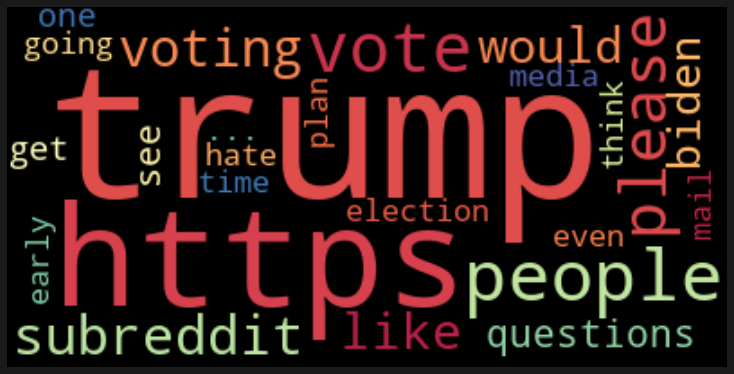

In [151]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(left_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
# plt.savefig('not_satire_wordcloud.png')

plt.show()

In [153]:
X = df['body']
y = df['comment_class']

In [154]:
#apply above function to data

processed_comments = list(map(process_comment, X))

In [155]:
#create list with lemmatized output
lemmatized_output = []

for comment in processed_comments:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in comment])
    lemmatized_output.append(lemmed)

In [156]:
X_lem = lemmatized_output

y_lem = y

In [157]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.35, random_state=1)
tfidf = TfidfVectorizer(ngram_range=(1,2))

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

tfidf_data_train_lem

<33900x421559 sparse matrix of type '<class 'numpy.float64'>'
	with 1940994 stored elements in Compressed Sparse Row format>

## Random Forest

In [158]:
rfc_lemma = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1,verbose=1)
rfc_lemma.fit(tfidf_data_train_lem, y_train_lem)
rf_test_preds = rfc_lemma.predict(tfidf_data_test_lem)

rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Random Forest with Lemmatization Features
Testing Accuracy: 0.9244

F1 Score: 0.9231


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


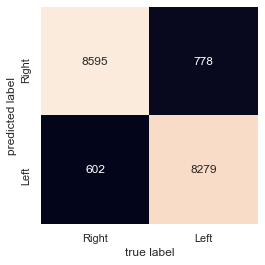

In [159]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, rf_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## MN Naive Bayes

In [160]:
mnb_lemma = MultinomialNB()
mnb_lemma.fit(tfidf_data_train_lem, y_train_lem)
mnb_test_preds = mnb_lemma.predict(tfidf_data_test_lem)

mnb_acc_score_lem = accuracy_score(y_test_lem, mnb_test_preds)
mnb_f1_score_lem = f1_score(y_test_lem, mnb_test_preds)
print('Multinomial Naive Bayes model accuracy')
print("Testing Accuracy: {:.4}".format(mnb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(mnb_f1_score_lem))

Multinomial Naive Bayes model accuracy
Testing Accuracy: 0.8965

F1 Score: 0.9001


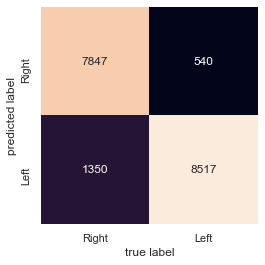

In [161]:
mat = confusion_matrix(y_test_lem, mnb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [162]:
y_test_lem.index

Int64Index([18327,  3122, 90657, 48424,  5548, 61594, 90412, 83516, 22273,
            65234,
            ...
            47277, 53703, 58933, 56836, 81269, 62419, 89528, 15599, 61060,
            17286],
           dtype='int64', length=18254)

In [163]:
test = comments_df.loc[y_test_lem.index]
test['pred'] = rf_test_preds
test['pred'] = test['pred'].apply(lambda x: 'right' if x == 1 else 'left')

In [164]:
guessed_right_wrong = test[(test.comment_class != test.pred) & (test.pred == 'right')]
guessed_right_wrong.reset_index(drop=True, inplace=True)

guessed_left_wrong = test[(test.comment_class != test.pred) & (test.pred == 'left')]
guessed_left_wrong.reset_index(drop=True, inplace=True)


In [165]:
print("GUESSED RIGHT BUT WE WERE WRONG")
print("_______________________________")
for i in range(0,50):
    print(guessed_right_wrong.iloc[i].body)

GUESSED RIGHT BUT WE WERE WRONG
_______________________________
Depends.  If you continue to maximize farm subsidies and hold payments to people in the cities to zero, they will "understand that you gotta do what you gotta do."
"I'm sorry Air Force One but you're going to have to circle. We're waiting on the credit card to process the payment. You may want to see if someone has another card we can try...."
this is no different from the way kids at school are exposed to sick ideas like accepting trans freaks etc tbh
Yes but they voted for him before didnt they?

Dont get me wrong, I am glad they changed their minds, but conservatives are not my favorite people right now.
I dont understand why people or groups do this. The person never resign or apologize or whatever else they're calling for
Let’s be honest, there’s nothing progressive about joe biden. He’s a diehard liberal who only really cares about corporations.....but even then he’s still vastly better than the competition.
Fun?   


In [166]:
print("GUESSED LEFT BUT WE WERE WRONG")
print("______________________________")
for i in range(0,50):
    print(guessed_left_wrong.iloc[i].body)

GUESSED LEFT BUT WE WERE WRONG
______________________________
You are your safest sex partner.   Wash your hands before masturbating.  Solid advice for the basement dweller who frequent here to brigade.
Look at the EBR-2 reactor design on wikipedia.  All the accidents have been caused by loss of coolant to the reactor.  The EBR-2 is passively safe.  When coolant is lost the nuclear fission stops.
Investigate the event, charge who did it with whatever charges are warranted. Hold fair trial.

I'm hoping this is what happens.

I have a feeling these crazies have a different definition of justice.
My left friends don't get this, but Trump's anti war stance is one of the big reasons I like him so much.
It is like saying Giordano Bruno was obviously making political partisan statements and it lead to erosion of trust in science.

Science cannot work when powerful figure, like President of US directly and without any evidence rallies against it when it does not align with his instincts. Of co